# Análise de Sentimento no Twitter

# 1. Introdução

Este notebook tem como objetivo realizar uma análise de sentimentos em uma base de tweets, aplicando técnicas de processamento de linguagem natural (NLP). Serão realizadas as seguintes etapas:

Pré-processamento: Limpeza e padronização dos textos.

Exploração dos dados: Visualização de palavras mais frequentes por categoria de sentimento.

Modelagem: Utilização da técnica Bag of Words (BoW) e classificação por Regressão Logística.

Avaliação: Verificação do desempenho do modelo nos conjuntos de teste e validação.

# 2. Definindo bibliotecas e datasets

2.1 Importação de Bibliotecas

In [31]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

# Bibliotecas para visualização
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para NLP e modelagem
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

2.2 Carregamento dos Dados

In [32]:
# Carregar dataset de validação
val=pd.read_csv("https://raw.githubusercontent.com/Brennu/Projeto-Aplicado-II/refs/heads/main/Dataset/twitter_validation.csv", header=None)
# Carregar dataset de treinamento
train=pd.read_csv("https://raw.githubusercontent.com/Brennu/Projeto-Aplicado-II/refs/heads/main/Dataset/twitter_training.csv", header=None)

# Renomeando colunas
train.columns = ['id', 'information', 'type', 'text']
val.columns = ['id', 'information', 'type', 'text']

train_data=train
val_data=val

# Visualizar primeiras linhas
print("Dados de Treino:")
display(train_data.head())
print("\nDados de Validação:")
display(val_data.head())

Dados de Treino:


,id,information,type,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...



Dados de Validação:


,id,information,type,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


# 3. Tratando os datasets

3.1 Conversão para minúsculas

In [33]:
#Transforma todo o texto para lowercase para padronização
#Isso evita diferenciação entre palavras com caixas diferentes
train_data["lower"]=train_data.text.str.lower()
val_data["lower"]=val_data.text.str.lower()

3.2 Garantindo tipo string

In [34]:
# Converte todos os valores para string, incluindo números isolados (como '2')
# Isso é necessário pois alguns tweets podem conter apenas números
train_data["lower"]=[str(data) for data in train_data.lower]
val_data["lower"]=[str(data) for data in val_data.lower]

3.3 Limpeza com expressões regulares

In [35]:
#Remove caracteres especiais, pontuações e símbolos
#Mantém apenas letras, números e espaços
#Importante para tweets que podem conter erros de digitação ou formatação
train_data["lower"]=train_data.lower.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))
val_data["lower"]=val_data.lower.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))

# 4. Nuvens de Palavras por Sentimento

4.1 Positive Tweets Word Cloud

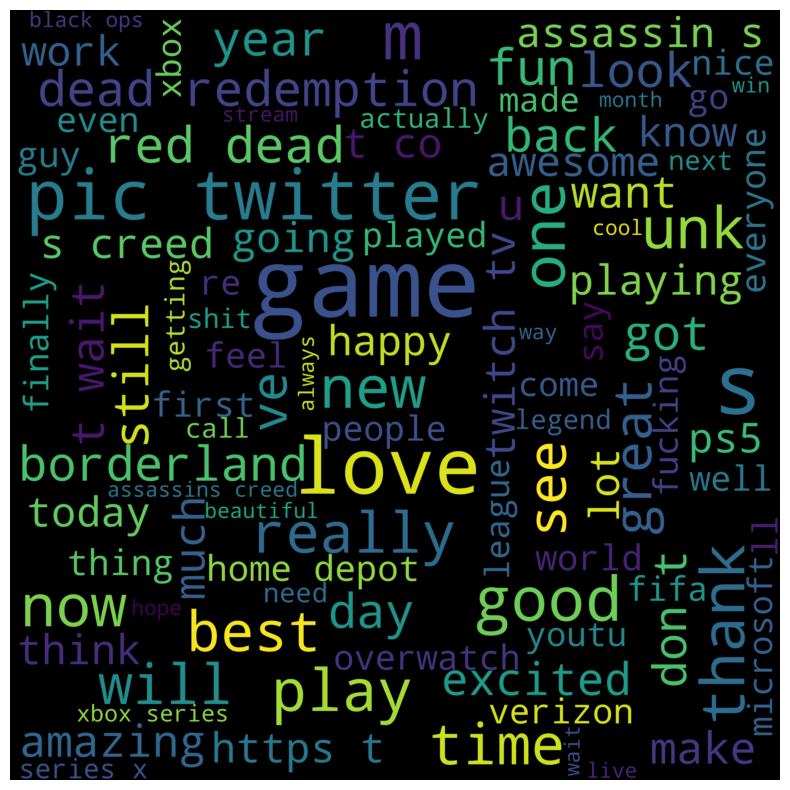

In [36]:
#Palavras mais frequentes em tweets positivos incluem termos como "love" e "game", além de outras palavras associadas a sentimentos positivos.
# A diversidade lexical é maior nesta categoria.
word_cloud_text = ''.join(train_data[train_data["type"]=="Positive"].lower)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

4.2 Negative Tweets Word Cloud

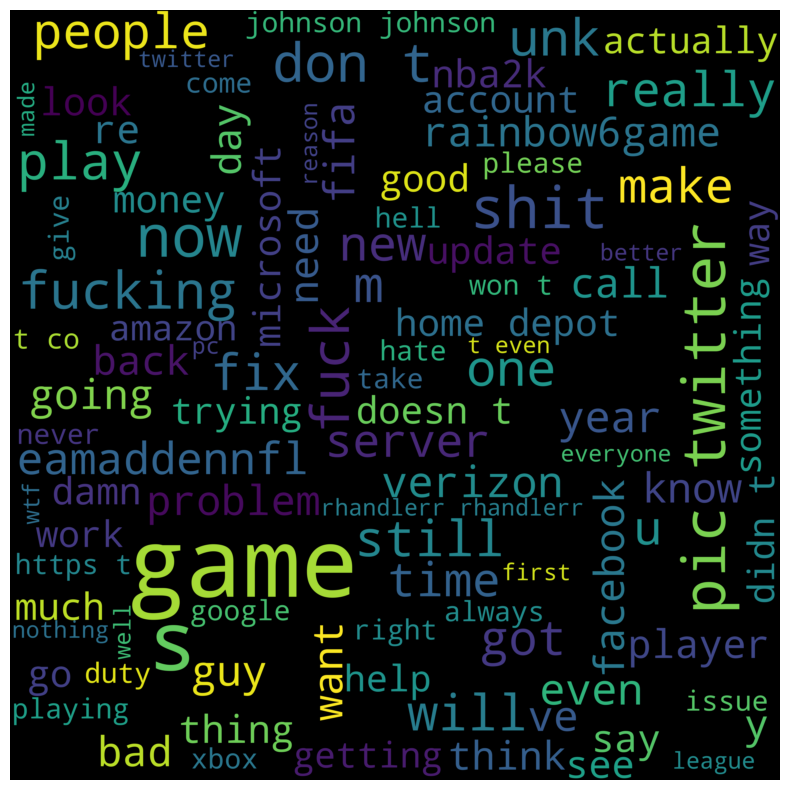

In [37]:
# Tweets negativos apresentam palavrões com frequência, além de menções a empresas/games específicos como 'facebook' e 'eamaddennfl'.
# Isso pode indicar reclamações direcionadas a essas marcas.
word_cloud_text = ''.join(train_data[train_data["type"]=="Negative"].lower)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

4.3 Irrelevant Tweets Word Cloud

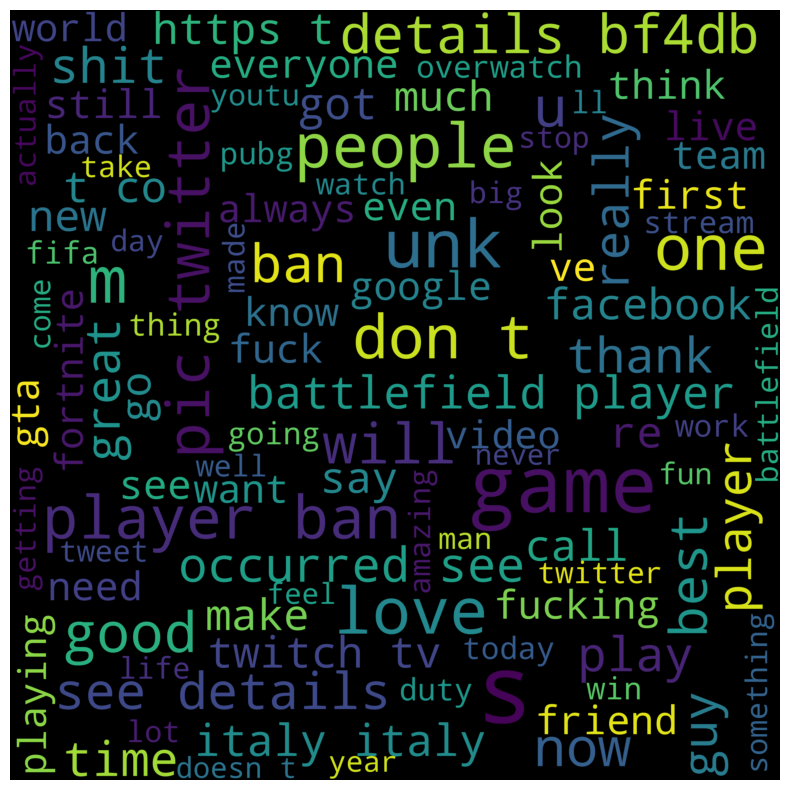

In [38]:
# Padrão similar aos tweets negativos, o que pode impactar a performance do modelo,sugerindo possível sobreposição entre essas categorias.
word_cloud_text = ''.join(train_data[train_data["type"]=="Irrelevant"].lower)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

4.4 Neutral Tweets Word Cloud

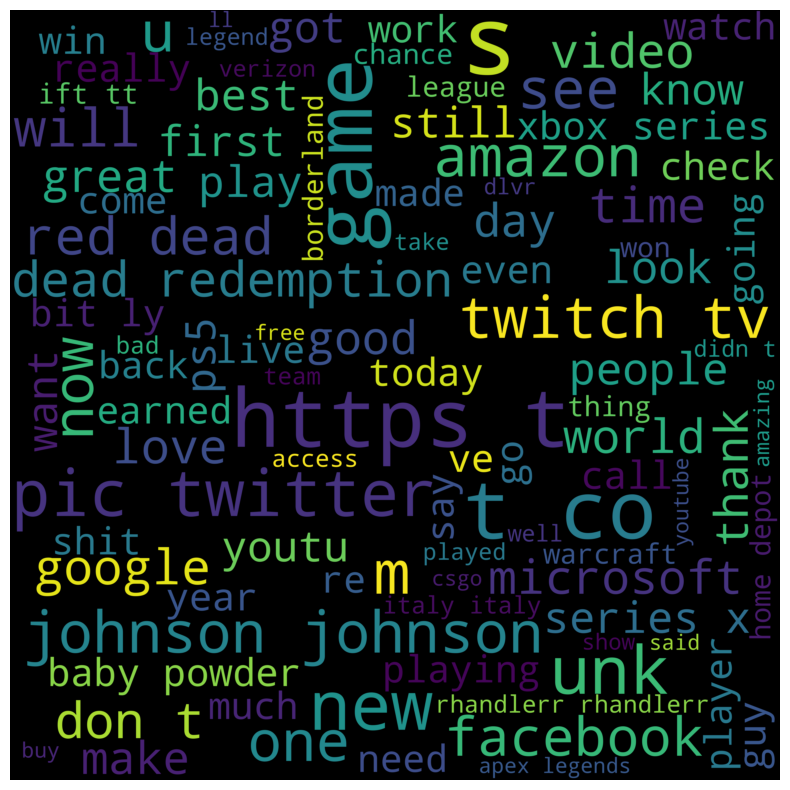

In [39]:
# Apresenta perfil lexical distinto, com quase nenhum palavrão e palavras-chave diferentes das outras categorias, indicando maior neutralidade.
word_cloud_text = ''.join(train_data[train_data["type"]=="Neutral"].lower)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

4.5  Distribuição de Tweets por Marca

In [40]:
# Pré-processamento dos dados
# Agrupamento por marca e tipo para contagem, usando 'id' como referência
plot1 = train.groupby(by=["information","type"]).count().reset_index()
plot1.head()

,information,type,id,text,lower
0,Amazon,Irrelevant,192,186,192
1,Amazon,Negative,576,575,576
2,Amazon,Neutral,1236,1207,1236
3,Amazon,Positive,312,308,312
4,ApexLegends,Irrelevant,192,192,192


4.6 Visualização em Barras

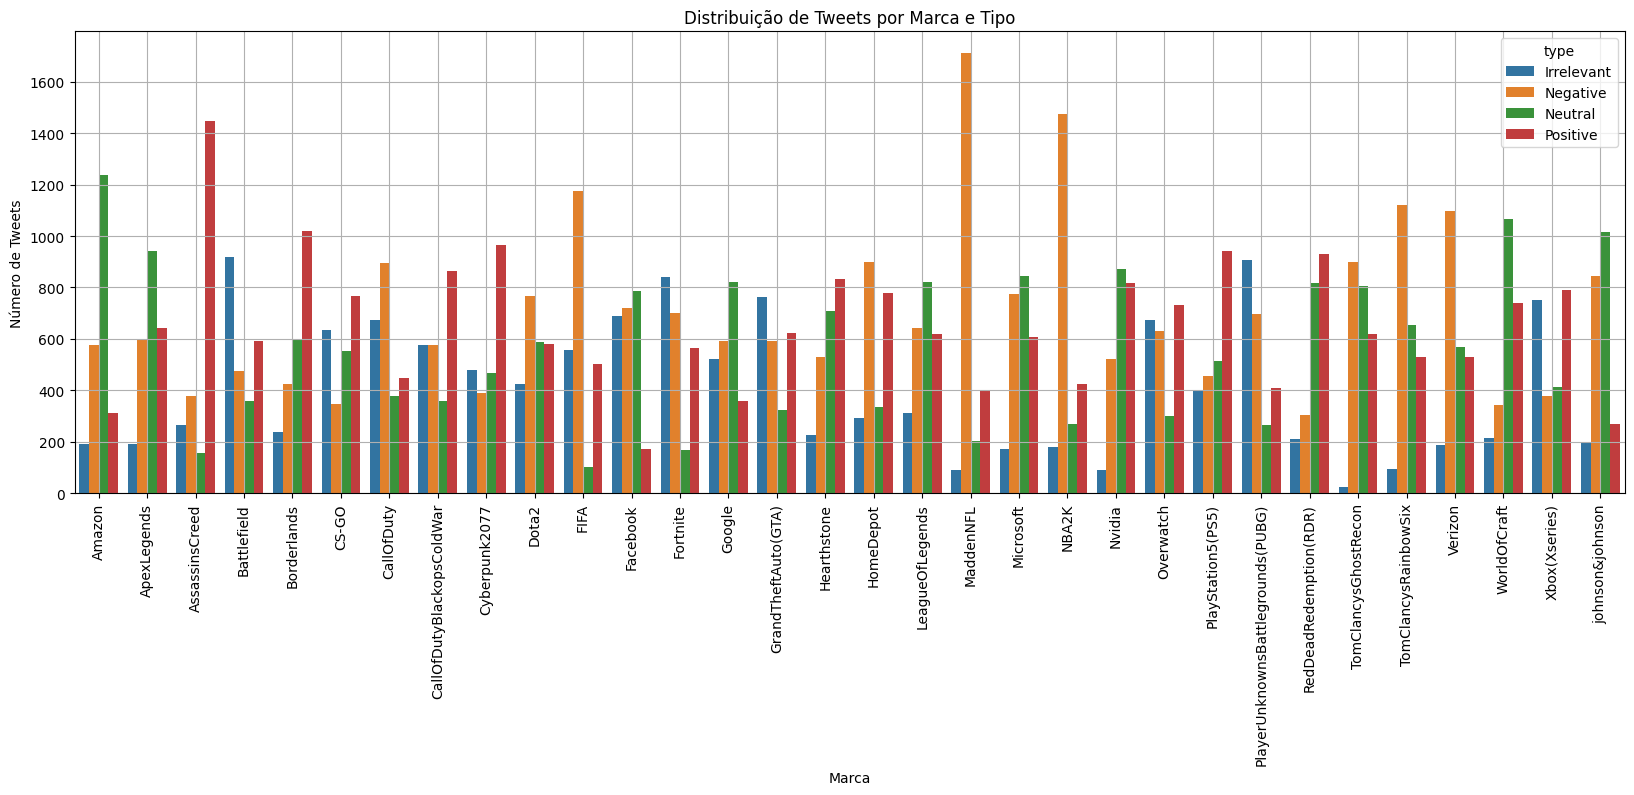

In [41]:
# Mostra distribuição desigual de sentimentos entre marcas:
# MaddenNFL e NBA2K têm predominância de tweets negativos
# Outras marcas apresentam distribuição mais balanceada
# Neutral é geralmente a categoria mais frequente

plt.figure(figsize=(20,6))
sns.barplot(data=plot1,x="information",y="id",hue="type")
plt.xticks(rotation=90)
plt.xlabel("Marca")
plt.ylabel("Número de Tweets")
plt.grid()
plt.title("Distribuição de Tweets por Marca e Tipo");

# 5. Tokenização

5.1 Tokenização do texto processado

In [73]:
# Transforma cada tweet em uma lista de palavras individuais (tokens)
tokens_text = [word_tokenize(str(word)) for word in train_data.lower]

5.2 Contagem de tokens únicos

In [74]:
# Achata a lista de listas em uma única lista e calcula elementos únicos
# O tamanho do vocabulário (30,436 tokens) indica alta dimensionalidade, o que pode impactar a performance do modelo
tokens_counter = [item for sublist in tokens_text for item in sublist]
print("Número de tokens únicos: ", len(set(tokens_counter)))

Número de tokens únicos:  30436


5.3 Exemplo de saída tokenizada

In [75]:
# Demonstra como o texto foi dividido em unidades linguísticas básicas
tokens_text[1]

['i',
 'am',
 'coming',
 'to',
 'the',
 'borders',
 'and',
 'i',
 'will',
 'kill',
 'you',
 'all']

# 6. Modelo de Regressão Logística

6.1 Configuração Inicial do Bag of Words (BoW)

In [76]:
# N-grams de 1 a 4 palavras (captura frases e contextos)
# Sem remoção de stopwords (pode preservar informações contextuais)
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)  # Captura uni-, bi-, tri- e four-grams
)

6.2 Divisão dos Dados e Vetorização

In [77]:
# Split estratificado (80% treino, 20% teste)
# random_state=0 garante reprodutibilidade
reviews_train, reviews_test = train_test_split(train_data, test_size=0.2, random_state=0)

6.3 Vetorização dos dados

In [78]:
# Aprende o vocabulário apenas com dados de treino
# Aplica a mesma transformação nos dados de teste
X_train_bow = bow_counts.fit_transform(reviews_train.lower)  # Treino + vocabulário
X_test_bow = bow_counts.transform(reviews_test.lower)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


6.4 Matriz esparsa resultante

In [79]:
# Formato (n_tweets, n_palavras_únicas) com contagem de ocorrências
X_test_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 803906 stored elements and shape (14937, 1427378)>

6.5 Definição dos Rótulos das Classes

In [80]:
y_train_bow = reviews_train['type']
y_test_bow = reviews_test['type']

6.6 Distribuição das classes

In [81]:
#Mostra desbalanceamento moderado com predominância de tweets Negativos e Positivos
y_test_bow.value_counts() / y_test_bow.shape[0]

,count
type,
Negative,0.299190
Positive,0.282252
Neutral,0.245632
Irrelevant,0.172926


6.7 Criação do modelo

In [82]:
# C=0.9: Regularização ligeiramente maior
# max_iter=1500: Garantir convergência
model = LogisticRegression(C=0.9, solver="liblinear", max_iter=1500)

6.8 Treinando o modelo

In [ ]:
model.fit(X_train_bow, y_train_bow)

6.9 Avaliação de Acurácia no Conjunto de Teste (20%)

In [ ]:
test_pred = model.predict(X_test_bow)
print("Acurácia: ", accuracy_score(y_test_bow, test_pred) * 100)

6.10 Avaliação de Acurácia no Conjunto de Validação

In [ ]:
y_val_bow = val_data['type']
X_val_bow = bow_counts.transform(val_data["lower"])
Val_pred = model.predict(X_val_bow)
print("Acurácia: ", accuracy_score(y_val_bow, Val_pred) * 100)